In [1]:
#for data processing
import pandas as pd
import numpy as np
import string
import re

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#for nlp
from collections import Counter
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#for regression model

from sklearn import metrics

#for evaluation
import scipy

In [2]:
#load train data
cols = ['id', 'text', 'label', 'intensity']

anger_train = pd.read_csv('/content/drive/MyDrive/iqgateway/train/anger-ratings-0to1.train.txt', header=None, sep='\t', names=cols, index_col=0)
fear_train = pd.read_csv('/content/drive/MyDrive/iqgateway/train/fear-ratings-0to1.train.txt', header=None, sep='\t', names=cols, index_col=0)
sad_train = pd.read_csv('/content/drive/MyDrive/iqgateway/train/sadness-ratings-0to1.train.txt', header=None, sep='\t', names=cols, index_col=0)
joy_train = pd.read_csv('/content/drive/MyDrive/iqgateway/train/joy-ratings-0to1.train.txt', header=None, sep='\t', names=cols, index_col=0)

joy_train.head()

,text,label,intensity
id,,,
30000,Just got back from seeing @GaryDelaney in Burs...,joy,0.980
30001,Oh dear an evening of absolute hilarity I don'...,joy,0.958
30002,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,0.940
30003,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,0.938
30004,I feel so blessed to work with the family that...,joy,0.938


In [3]:
frames = [anger_train, fear_train, sad_train, joy_train]
data_training = pd.concat(frames)
data_training.reset_index(inplace=True)
data_training.label.value_counts()

fear       1147
anger       857
joy         823
sadness     786
Name: label, dtype: int64

In [4]:
data_training.head()

,id,text,label,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [5]:
punc = string.punctuation
data_training['word_count'] = data_training['text'].apply(lambda x:len(x.split()))
data_training['char_count'] = data_training['text'].apply(lambda x:len(x.replace(' ','')))
data_training['punc_count'] = data_training['text'].apply(lambda x:len([a for a in x if a in punc]))
data_training.head()

,id,text,label,intensity,word_count,char_count,punc_count
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,18,79,12
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,23,97,4
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,19,90,4
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,24,111,13
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,24,102,6


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
#Cleaning text by removing links, numbers, @, stopwords, and transform all to lower case
from nltk.corpus import stopwords

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[A-Za-z0-9./]+'
pat3 = r'[0-9]+'
combined_pat = r'|'.join((pat1, pat2, pat3))
stop_words= set(stopwords.words('english'))

def tweet_cleaner(data_frame):
    print('Cleaning and parsing the tweets.....\n')
    clean_data = []
    for index, row in data_frame.iterrows():
        stripped = re.sub(combined_pat, '', row.text)
        lower_case = stripped.lower()
        words = tok.tokenize(lower_case)
        filtered_words = [w for w in words if not w in stop_words]
        clean_data.append((' '.join(filtered_words)).strip())
        
    print('Done!')
    return clean_data

In [8]:
clean_data_training_list = tweet_cleaner(data_training)

Cleaning and parsing the tweets.....

Done!


In [9]:
data_training.text = pd.DataFrame(clean_data_training_list)
data_training.head()

,id,text,label,intensity,word_count,char_count,punc_count
0,10000,fu * k ! heck ! moved fridge !... knock landlo...,anger,0.938,18,79,12
1,10001,indian uber driver called someone n word . ' m...,anger,0.896,23,97,4
2,10002,asked parcel delivered pick store address # fu...,anger,0.896,19,90,4
3,10003,ef whichever butt wipe pulled fire alarm davis...,anger,0.896,24,111,13
4,10004,"' join put phone , talk rude . taking money ac...",anger,0.896,24,102,6


In [10]:
#making one-hot encoding of label
labels = pd.get_dummies(data_training['label'])



vectorizer_tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer_tfidf.fit_transform(data_training.text)
X_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf).join(labels)

In [11]:
X_tfidf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,anger,fear,joy,sadness
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.469521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.403406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
3609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
3610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
3611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0


In [12]:
train_X = X_tfidf.copy()

In [13]:
train_X.to_numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [15]:
train_Y=data_training['intensity'].copy()
train_Y.to_numpy()

array([0.938, 0.896, 0.896, ..., 0.04 , 0.02 , 0.019])

In [17]:
#Load data development to test the models
cols = ['id', 'text', 'label', 'intensity']

#path = "../input/wassa2017-emotion-intensity/"
anger_dev = pd.read_csv('/content/drive/MyDrive/iqgateway/dev/with/anger-ratings-0to1.dev.gold.txt', header=None, sep='\t', names=cols, index_col=0)
fear_dev = pd.read_csv('/content/drive/MyDrive/iqgateway/dev/with/fear-ratings-0to1.dev.gold.txt', header=None, sep='\t', names=cols, index_col=0)
sad_dev = pd.read_csv('/content/drive/MyDrive/iqgateway/dev/with/sadness-ratings-0to1.dev.gold.txt', header=None, sep='\t', names=cols, index_col=0)
joy_dev = pd.read_csv('/content/drive/MyDrive/iqgateway/dev/with/joy-ratings-0to1.dev.gold.txt', header=None, sep='\t', names=cols, index_col=0)

joy_dev.head()

,text,label,intensity
id,,,
30823,"@theclobra lol I thought maybe, couldn't decid...",joy,0.312
30824,Nawaz Sharif is getting more funnier than @kap...,joy,0.700
30825,Nawaz Sharif is getting more funnier than @kap...,joy,0.580
30826,@tomderivan73 😁...I'll just people watch and e...,joy,0.438
30827,I love my family so much #lucky #grateful #sma...,joy,0.936


In [18]:
frames = [anger_dev, fear_dev, sad_dev, joy_dev]
data_dev = pd.concat(frames)
data_dev.reset_index(inplace=True)
data_dev.label.value_counts()

fear       110
anger       84
joy         79
sadness     74
Name: label, dtype: int64

In [19]:
clean_data_dev_list = tweet_cleaner(data_dev)

Cleaning and parsing the tweets.....

Done!


In [20]:
data_dev.text = pd.DataFrame(clean_data_dev_list)
data_dev.head()

,id,text,label,intensity
0,10857,pls dont insult word ' molna ',anger,0.479
1,10858,would almost took offense actually snapped,anger,0.458
2,10859,rutgers game abomination . affront god man . m...,anger,0.562
3,10860,"' lisa asked started raging , ' call ?' heh",anger,0.500
4,10861,sometimes get mad something minuscule try ruin...,anger,0.708


In [21]:
labels = pd.get_dummies(data_dev['label'])


X_Dev_tfidf = vectorizer_tfidf.transform(data_dev['text'])
X_Dev_tfidf = pd.DataFrame.sparse.from_spmatrix(X_Dev_tfidf).join(labels)

In [22]:
val_X = X_Dev_tfidf.copy()

In [23]:
val_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,anger,fear,joy,sadness
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.561255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.437772,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.481409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.349276,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
343,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
344,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.424204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
345,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.487924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0


In [24]:
val_X.to_numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [25]:
val_Y=data_dev['intensity'].copy()
val_Y.to_numpy()

array([0.479, 0.458, 0.562, 0.5  , 0.708, 0.646, 0.25 , 0.812, 0.682,
       0.438, 0.646, 0.726, 0.348, 0.417, 0.202, 0.557, 0.5  , 0.521,
       0.5  , 0.646, 0.5  , 0.86 , 0.438, 0.417, 0.604, 0.429, 0.25 ,
       0.586, 0.5  , 0.708, 0.417, 0.438, 0.417, 0.833, 0.312, 0.708,
       0.526, 0.479, 0.271, 0.542, 0.417, 0.415, 0.241, 0.167, 0.5  ,
       0.542, 0.375, 0.125, 0.604, 0.708, 0.438, 0.427, 0.292, 0.375,
       0.354, 0.438, 0.562, 0.542, 0.667, 0.542, 0.25 , 0.438, 0.708,
       0.518, 0.5  , 0.438, 0.375, 0.396, 0.375, 0.812, 0.37 , 0.446,
       0.583, 0.667, 0.417, 0.5  , 0.333, 0.521, 0.604, 0.562, 0.625,
       0.292, 0.229, 0.604, 0.771, 0.479, 0.417, 0.475, 0.542, 0.542,
       0.311, 0.438, 0.729, 0.812, 0.702, 0.438, 0.667, 0.542, 0.5  ,
       0.354, 0.375, 0.52 , 0.25 , 0.25 , 0.667, 0.389, 0.812, 0.583,
       0.333, 0.438, 0.292, 0.72 , 0.356, 0.34 , 0.792, 0.479, 0.06 ,
       0.479, 0.208, 0.7  , 0.688, 0.562, 0.642, 0.604, 0.583, 0.292,
       0.229, 0.708,

deep model


In [26]:
import tensorflow

In [27]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
model = Sequential()
model.add(Dense(1004, input_dim=1004, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimiser = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', optimizer=optimiser ,metrics=["mae"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1004)              1009020   
_________________________________________________________________
dropout (Dropout)            (None, 1004)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               514560    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

In [28]:
#from keras.callbacks import EarlyStopping
#stopping_criterions =[EarlyStopping(monitor='accuracy', mode='max', patience =5)]
history = model.fit(train_X,train_Y,batch_size=32,epochs=10,validation_data=(val_X,val_Y),shuffle=True,verbose=1)#callbacks=stopping_criterions


Epoch 1/10
113/113 [==============================] - 4s 28ms/step - loss: 0.1491 - mae: 0.1491 - val_loss: 0.1346 - val_mae: 0.1346
Epoch 2/10
113/113 [==============================] - 3s 22ms/step - loss: 0.1173 - mae: 0.1173 - val_loss: 0.1376 - val_mae: 0.1376
Epoch 3/10
113/113 [==============================] - 3s 23ms/step - loss: 0.0978 - mae: 0.0978 - val_loss: 0.1270 - val_mae: 0.1270
Epoch 4/10
113/113 [==============================] - 3s 23ms/step - loss: 0.0836 - mae: 0.0836 - val_loss: 0.1293 - val_mae: 0.1293
Epoch 5/10
113/113 [==============================] - 3s 23ms/step - loss: 0.0721 - mae: 0.0721 - val_loss: 0.1302 - val_mae: 0.1302
Epoch 6/10
113/113 [==============================] - 3s 22ms/step - loss: 0.0659 - mae: 0.0659 - val_loss: 0.1282 - val_mae: 0.1282
Epoch 7/10
113/113 [==============================] - 3s 23ms/step - loss: 0.0612 - mae: 0.0612 - val_loss: 0.1325 - val_mae: 0.1325
Epoch 8/10
113/113 [==============================] - 3s 22ms/step - 

In [29]:

y_actual = data_dev['intensity']
y_predicted = model.predict(val_X)
y_predicted1 = np.squeeze(y_predicted,axis=1)
pd.DataFrame(data={"Actual Intensity" : data_dev['intensity'], "Predicted Intensity" : y_predicted1})

,Actual Intensity,Predicted Intensity
0,0.479,0.488089
1,0.458,0.403660
2,0.562,0.520616
3,0.500,0.618314
4,0.708,0.394173
...,...,...
342,0.580,0.506559
343,0.170,0.526151
344,0.396,0.301432
345,0.156,0.295120


In [30]:
#Training the final model with the combination of training and development data
combined_training = pd.concat([data_training[['id', 'text', 'label', 'intensity']], data_dev]).reset_index()
combined_training.shape

(3960, 5)

In [31]:
combined_training

,index,id,text,label,intensity
0,0,10000,fu * k ! heck ! moved fridge !... knock landlo...,anger,0.938
1,1,10001,indian uber driver called someone n word . ' m...,anger,0.896
2,2,10002,asked parcel delivered pick store address # fu...,anger,0.896
3,3,10003,ef whichever butt wipe pulled fire alarm davis...,anger,0.896
4,4,10004,"' join put phone , talk rude . taking money ac...",anger,0.896
...,...,...,...,...,...
3955,342,30897,feels good get outside minute get fresh air . ...,joy,0.580
3956,343,30898,ppl get triggered u smiling ' irrelevant,joy,0.170
3957,344,30899,snapchat new would beg differ # optimism,joy,0.396
3958,345,30900,snapchat new would beg differ,joy,0.156


In [32]:
#ANGER
anger = combined_training.loc[combined_training['label']=='anger']
anger_vectorizer = TfidfVectorizer(max_features=1000)
X_anger = anger_vectorizer.fit_transform(anger['text'])
#anger_model = svm.SVR().fit(X_anger, anger['intensity'])

#FEAR
fear = combined_training.loc[combined_training['label']=='fear']
fear_vectorizer = TfidfVectorizer(max_features=1000)
X_fear = fear_vectorizer.fit_transform(fear['text'])
#fear_model = svm.SVR().fit(X_fear, fear['intensity'])

#SADNESS
sad = combined_training.loc[combined_training['label']=='sadness']
sad_vectorizer = TfidfVectorizer(max_features=1000)
X_sad = sad_vectorizer.fit_transform(sad['text'])
#sad_model = svm.SVR().fit(X_sad, sad['intensity'])

#JOY
joy = combined_training.loc[combined_training['label']=='joy']
joy_vectorizer = TfidfVectorizer(max_features=1000)
X_joy = joy_vectorizer.fit_transform(joy['text'])
#joy_model = svm.SVR().fit(X_joy, joy['intensity'])

In [33]:
#Load testing data
cols = ["id", "text", "label", "intensity"]


anger_test = pd.read_csv('/content/drive/MyDrive/iqgateway/test/with/anger-ratings-0to1.test.gold.txt', header=None, sep="\t", names=cols, index_col=0)
fear_test = pd.read_csv('/content/drive/MyDrive/iqgateway/test/with/fear-ratings-0to1.test.gold.txt', header=None, sep="\t", names=cols, index_col=0)
sad_test = pd.read_csv('/content/drive/MyDrive/iqgateway/test/with/sadness-ratings-0to1.test.gold.txt', header=None, sep="\t", names=cols, index_col=0)
joy_test = pd.read_csv('/content/drive/MyDrive/iqgateway/test/with/joy-ratings-0to1.test.gold.txt', header=None, sep="\t", names=cols, index_col=0)

anger_test.head()

,text,label,intensity
id,,,
10941,At the point today where if someone says somet...,anger,0.319
10942,@CorningFootball IT'S GAME DAY!!!! T MIN...,anger,0.144
10943,This game has pissed me off more than any othe...,anger,0.898
10944,@spamvicious I've just found out it's Candice ...,anger,0.271
10945,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,anger,0.646


In [34]:
frames = [anger_test, fear_test, sad_test, joy_test]
data_test = pd.concat(frames)
data_test.reset_index(inplace=True)
data_test.label.value_counts()

fear       995
anger      760
joy        714
sadness    673
Name: label, dtype: int64

In [35]:
data_test.head()

,id,text,label,intensity
0,10941,At the point today where if someone says somet...,anger,0.319
1,10942,@CorningFootball IT'S GAME DAY!!!! T MIN...,anger,0.144
2,10943,This game has pissed me off more than any othe...,anger,0.898
3,10944,@spamvicious I've just found out it's Candice ...,anger,0.271
4,10945,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,anger,0.646


In [36]:
clean_data_test_list = tweet_cleaner(data_test)

Cleaning and parsing the tweets.....

Done!


In [37]:
#cleaning the test data
anger_text = tweet_cleaner(anger_test)
fear_text = tweet_cleaner(fear_test)
sad_text = tweet_cleaner(sad_test)
joy_text = tweet_cleaner(joy_test)

Cleaning and parsing the tweets.....

Done!
Cleaning and parsing the tweets.....

Done!
Cleaning and parsing the tweets.....

Done!
Cleaning and parsing the tweets.....

Done!


In [38]:
#ANGER
X_anger_test = anger_vectorizer.transform(anger_text)
X_anger_test = pd.DataFrame.sparse.from_spmatrix(X_anger_test)

X_anger_test[[ 'anger', 'fear','joy','sad']] = [1,0,0,0]

Y_anger_actual = anger_test['intensity']
Y_anger_predicted = model.predict(X_anger_test)

Y_anger_predicted = np.squeeze(Y_anger_predicted,axis=1)
pd.DataFrame(data={"Actual Intensity" : anger_test['intensity'], "Predicted Intensity" : Y_anger_predicted})


,Actual Intensity,Predicted Intensity
id,,
10941,0.319,0.386994
10942,0.144,0.515845
10943,0.898,0.425257
10944,0.271,0.505018
10945,0.646,0.496647
...,...,...
11696,0.646,0.390141
11697,0.125,0.443953
11698,0.542,0.286276


In [39]:
#FEAR
X_fear_test = fear_vectorizer.transform(fear_text)
X_fear_test = pd.DataFrame.sparse.from_spmatrix(X_fear_test)

X_fear_test[[ 'anger', 'fear','joy','sad']] = [0,1,0,0]

Y_fear_actual = fear_test['intensity']
Y_fear_predicted = model.predict(X_fear_test)

Y_fear_predicted = np.squeeze(Y_fear_predicted,axis=1)
pd.DataFrame(data={"Actual Intensity" : fear_test['intensity'], "Predicted Intensity" : Y_fear_predicted})


,Actual Intensity,Predicted Intensity
id,,
21257,0.417,0.186762
21258,0.438,0.371734
21259,0.542,0.219641
21260,0.583,0.433453
21261,0.292,0.420670
...,...,...
22247,0.354,0.330224
22248,0.812,0.430876
22249,0.580,0.659205


In [40]:
#JOY
X_joy_test = joy_vectorizer.transform(joy_text)
X_joy_test = pd.DataFrame.sparse.from_spmatrix(X_joy_test)

X_joy_test[[ 'anger', 'fear','joy','sad']] = [0,0,1,0]

Y_joy_actual = joy_test['intensity']
Y_joy_predicted = model.predict(X_joy_test)

Y_joy_predicted = np.squeeze(Y_joy_predicted,axis=1)
pd.DataFrame(data={"Actual Intensity" : joy_test['intensity'], "Predicted Intensity" : Y_joy_predicted})


,Actual Intensity,Predicted Intensity
id,,
30902,0.583,0.388408
30903,0.500,0.565608
30904,0.860,0.603993
30905,0.521,0.420190
30906,0.042,0.574656
...,...,...
31611,0.417,0.332728
31612,0.146,0.518933
31613,0.646,0.312290


In [41]:
#SADNESS
X_sad_test = sad_vectorizer.transform(sad_text)
X_sad_test = pd.DataFrame.sparse.from_spmatrix(X_sad_test)

X_sad_test[[ 'anger', 'fear','joy','sad']] = [0,0,0,1]

Y_sad_actual = sad_test['intensity']
Y_sad_predicted = model.predict(X_sad_test)

Y_sad_predicted = np.squeeze(Y_sad_predicted,axis=1)
pd.DataFrame(data={"Actual Intensity" : sad_test['intensity'], "Predicted Intensity" : Y_sad_predicted})


,Actual Intensity,Predicted Intensity
id,,
40860,0.667,0.332375
40861,0.458,0.345847
40862,0.396,0.351829
40863,0.271,0.633099
40864,0.604,0.278948
...,...,...
41528,0.396,0.577062
41529,0.604,0.360184
41530,0.479,0.471962


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Text(0.5, 1.0, 'JOY')

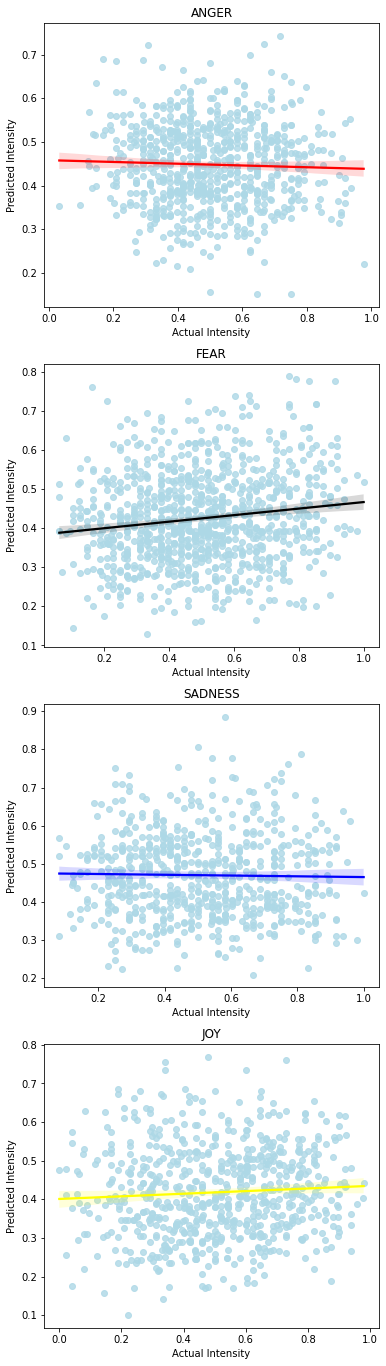

In [42]:
#Visualising the result of the predictions
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(6, 24))

#ANGER
sns.regplot(Y_anger_actual, Y_anger_predicted, ax=ax1, line_kws={'color':'red'}, scatter_kws={"color": "lightblue"})
ax1.set_xlabel("Actual Intensity")
ax1.set_ylabel("Predicted Intensity")
ax1.set_title("ANGER")

#FEAR
sns.regplot(Y_fear_actual, Y_fear_predicted, ax=ax2, line_kws={'color':'black'}, scatter_kws={"color": "lightblue"})
ax2.set_xlabel("Actual Intensity")
ax2.set_ylabel("Predicted Intensity")
ax2.set_title("FEAR")

#SADNESS
sns.regplot(Y_sad_actual, Y_sad_predicted, ax=ax3, line_kws={'color':'blue'}, scatter_kws={"color": "lightblue"})
ax3.set_xlabel("Actual Intensity")
ax3.set_ylabel("Predicted Intensity")
ax3.set_title("SADNESS")

#JOY
sns.regplot(Y_joy_actual, Y_joy_predicted, ax=ax4, line_kws={'color':'yellow'}, scatter_kws={"color": "lightblue"})
ax4.set_xlabel("Actual Intensity")
ax4.set_ylabel("Predicted Intensity")
ax4.set_title("JOY")

In [43]:
#Using the official evalution function
def evaluate(pred,gold):

    # lists storing gold and prediction scores
    gold_scores=[]  
    pred_scores=[]

    # lists storing gold and prediction scores where gold score >= 0.5
    gold_scores_range_05_1=[]
    pred_scores_range_05_1=[]
        
    for p in pred:
        pred_scores.append(p)
        
    for g in gold:
        gold_scores.append(g)

    for i in range(len(gold_scores)):
        if gold_scores[i] >= 0.5:
            gold_scores_range_05_1.append(gold_scores[i])
            pred_scores_range_05_1.append(pred_scores[i])

    
    # return zero correlation if predictions are constant
    if np.std(pred_scores)==0 or np.std(gold_scores)==0:
        return (0,0,0,0)
    

    pears_corr=scipy.stats.pearsonr(pred_scores,gold_scores)[0]                                     
    pears_corr_range_05_1=scipy.stats.pearsonr(pred_scores_range_05_1,gold_scores_range_05_1)[0]                                           
    
    
    return (pears_corr,pears_corr_range_05_1)

In [44]:
pear_results=[]
spear_results=[]

pear_results_range_05_1=[]
spear_results_range_05_1=[]

num_pairs = 4
argv = ["Anger_Actual", Y_anger_actual, "Anger_Predicted", Y_anger_predicted, "Fear_Actual", Y_fear_actual, "Fear_Predicted", Y_fear_predicted, "Sad_Actual", Y_sad_actual, "Sad_Predicted", Y_sad_predicted, "Joy_Actual", Y_joy_actual, "Joy_Predicted", Y_joy_predicted]

for i in range(0,num_pairs*4,4):
    name_gold = argv[i]
    gold=argv[i+1]
    name_pred = argv[i+2]
    pred=argv[i+3]       
    result=evaluate(pred,gold)
    
    print ("Pearson correlation between ", name_pred, " and ", name_gold, ":\t", str(result[0]))        
    pear_results.append(result[0])


    print ("Pearson correlation for gold scores in range 0.5-1 between ",name_pred," and ",name_gold,":\t",str(result[1]))       
    pear_results_range_05_1.append(result[1])


avg_pear=np.mean(pear_results)

avg_pear_range_05_1=np.mean(pear_results_range_05_1)

print ("Average Pearson correlation:\t",str(avg_pear))

print ("Average Pearson correlation for gold scores in range 0.5-1:\t", str(avg_pear_range_05_1))

Pearson correlation between  Anger_Predicted  and  Anger_Actual :	 -0.03688749175626993
Pearson correlation for gold scores in range 0.5-1 between  Anger_Predicted  and  Anger_Actual :	 -0.03159879625212958
Pearson correlation between  Fear_Predicted  and  Fear_Actual :	 0.14592644036160443
Pearson correlation for gold scores in range 0.5-1 between  Fear_Predicted  and  Fear_Actual :	 0.14143135830177986
Pearson correlation between  Sad_Predicted  and  Sad_Actual :	 -0.018547202860901054
Pearson correlation for gold scores in range 0.5-1 between  Sad_Predicted  and  Sad_Actual :	 -0.016704774993027006
Pearson correlation between  Joy_Predicted  and  Joy_Actual :	 0.06314000420061926
Pearson correlation for gold scores in range 0.5-1 between  Joy_Predicted  and  Joy_Actual :	 0.08318292499811666
Average Pearson correlation:	 0.03840793748626317
Average Pearson correlation for gold scores in range 0.5-1:	 0.044077678013684986
